In [17]:
import pandas as pd
from utils import get_repo_root
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks


In [4]:
repo_root = get_repo_root()

In [5]:
input_set = pd.read_csv(str(repo_root) + '/data/features_all.csv')
ref_test = pd.read_csv(str(repo_root) + '/data/referance_data_test.csv')
ref = pd.read_csv(str(repo_root) + '/data/referance_data.csv')

In [6]:
input_set_with_labels = input_set.merge(ref, on=['cust_id', 'ref_date'], how='left')
training_data = input_set_with_labels[input_set_with_labels['churn'].notna()]
test_data = input_set_with_labels[input_set_with_labels['churn'].isna()]

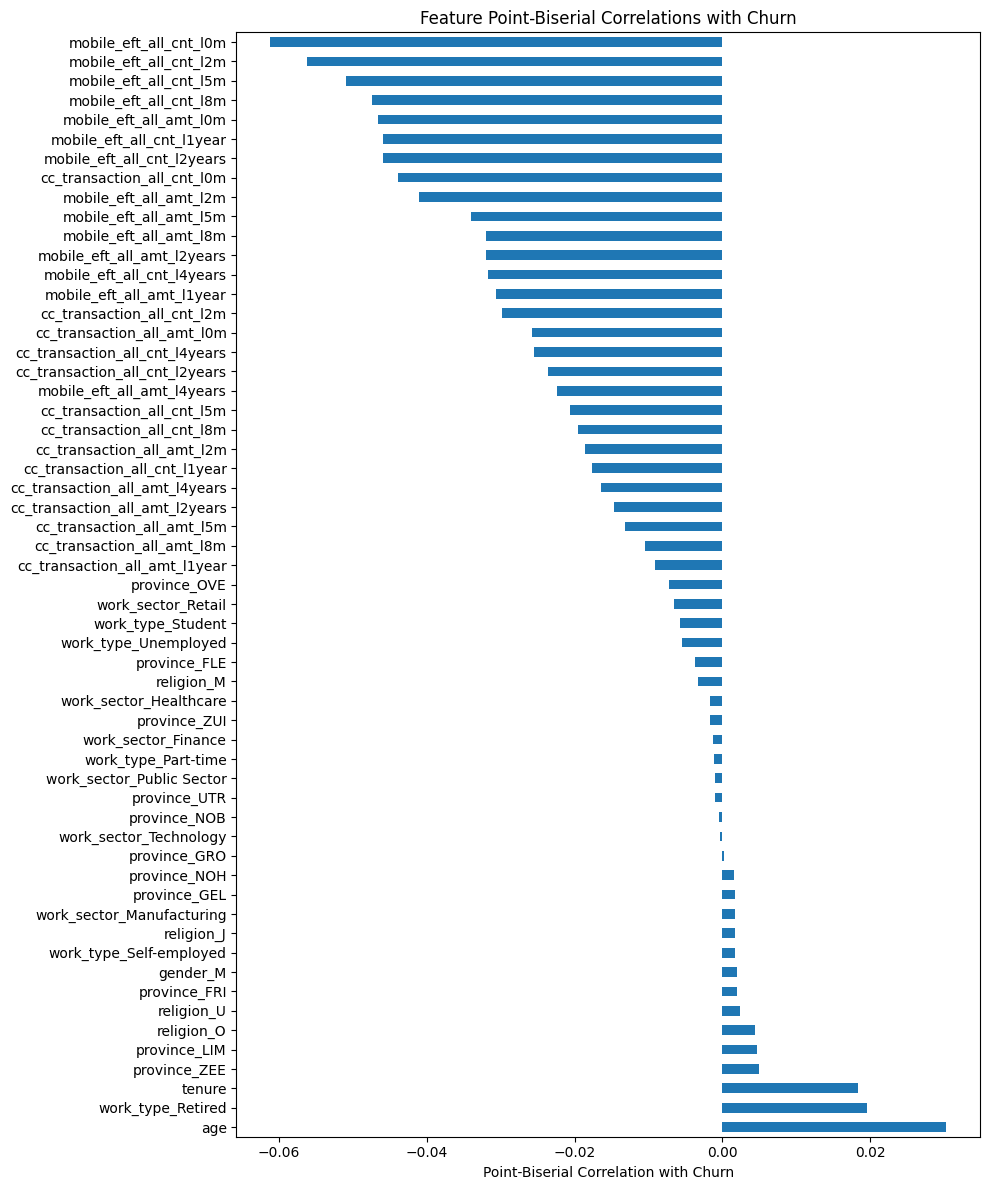

In [7]:
from scipy.stats import pointbiserialr

# Calculate point-biserial correlations with churn column
pb_correlations = {}
feature_cols = training_data.drop(['cust_id', 'ref_date', 'churn'], axis=1).columns

for col in feature_cols:
    corr, _ = pointbiserialr(training_data['churn'], training_data[col])
    pb_correlations[col] = corr

# Convert to Series and sort
pb_corr_series = pd.Series(pb_correlations).sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 12))
pb_corr_series.plot(kind='barh')
plt.xlabel('Point-Biserial Correlation with Churn')
plt.title('Feature Point-Biserial Correlations with Churn')
plt.tight_layout()
plt.show()

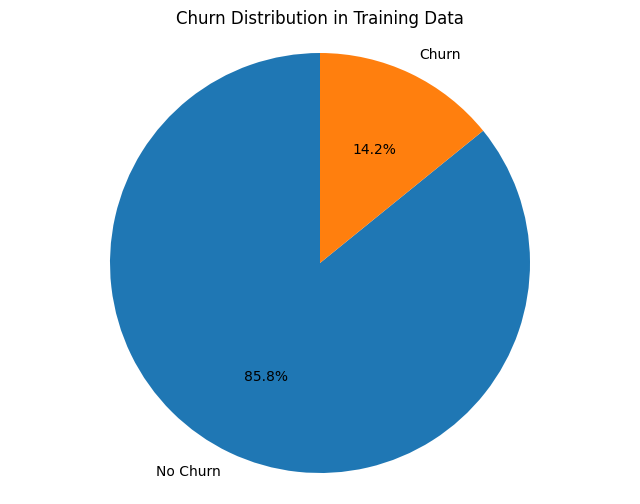

In [8]:
import matplotlib.pyplot as plt

# Count the values in churn column
churn_counts = training_data['churn'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution in Training Data')
plt.axis('equal')
plt.show()

## MODELLING

In [9]:
from utils.ml_functions import ing_hubs_datathon_metric 
from utils.ml_functions import OptunaTuner

In [10]:
X = training_data.iloc[:, 2:-1]
y = training_data['churn']

In [25]:
studies = {
     "None_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler=None,
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="None_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler="RandomOverSampler",
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler="SMOTE",
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_RandomForestClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="RandomForest",
        sampler="SMOTE",        
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_RandomForestClassifier_LogLoss_INGHubsMetric"
    )
}

In [15]:
study1 = studies["None_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: None_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 106629, Val size: 26658
  Train class dist: [91533 15096]
  Val class dist: [22884  3774]
  Pred proba range: [0.0000, 0.9672]
  Pred labels dist: [23868  2790]
[I 2025-10-19 23:50:11] Trial 0 finished with value: 0.47 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.47.
[I 2025-10-19 23:50:19] Trial 1 finished with value: 0.47 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 0.47.
[I 2025-10-19 23:50:35] Trial 2 finished with value: 0.60 and parameters: {'n_estimators': 812, 'learning_rate': '0.00', 

In [ ]:
study2 = studies["RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 183066, Val size: 26658
  Train class dist: [91533 91533]
  Val class dist: [22884  3774]
  Pred proba range: [0.0000, 0.9318]
  Pred labels dist: [25063  1595]
[I 2025-10-19 23:57:03] Trial 0 finished with value: 0.47 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.47.
[I 2025-10-19 23:57:10] Trial 1 finished with value: 0.49 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 1 with value: 0.49.
[I 2025-10-19 23:57:32] Trial 2 finished with value: 0.59 and parameters: {'n_estimators': 812, 'learning_ra

In [23]:
study3 = studies["SMOTE_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: SMOTE_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 183066, Val size: 26658
  Train class dist: [91533 91533]
  Val class dist: [22884  3774]
  Pred proba range: [0.0199, 0.5793]
  Pred labels dist: [26656     2]
[I 2025-10-20 00:24:58] Trial 0 finished with value: 0.51 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.51.
[I 2025-10-20 00:25:03] Trial 1 finished with value: 0.49 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 0.51.
[I 2025-10-20 00:25:24] Trial 2 finished with value: 0.41 and parameters: {'n_estimators': 812, 'learning_rate': '0.00',

TO DO 

* optimize fonksiyonunu study fonksiyonu olarak güncelle ve parametreleri + inputları + modeli bir JSON'a yazdır, bu JSON'ı return et.
* JSON dosyalarını kullanarak tekrar train et ve modeli .pkl olarak kaydet.
* feature kısmına daha doğru düzgün odaklan. 